In [18]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/yolo-models/yolov8x.pt
/kaggle/input/yolo-models/yolov8n.pt
/kaggle/input/yolo-models/coco/coco/val2017.txt
/kaggle/input/yolo-models/coco/coco/LICENSE
/kaggle/input/yolo-models/coco/coco/test-dev2017.txt
/kaggle/input/yolo-models/coco/coco/train2017.txt
/kaggle/input/yolo-models/coco/coco/README.txt
/kaggle/input/yolo-models/coco/coco/coco.yaml
/kaggle/input/yolo-models/coco/coco/labels/val2017/000000183675.txt
/kaggle/input/yolo-models/coco/coco/labels/val2017/000000382122.txt
/kaggle/input/yolo-models/coco/coco/labels/val2017/000000226130.txt
/kaggle/input/yolo-models/coco/coco/labels/val2017/000000572900.txt
/kaggle/input/yolo-models/coco/coco/labels/val2017/000000202228.txt
/kaggle/input/yolo-models/coco/coco/labels/val2017/000000509735.txt
/kaggle/input/yolo-models/coco/coco/labels/val2017/000000532690.txt
/kaggle/input/yolo-models/coco/coco/labels/val2017/000000078823.txt
/kaggle/input/yolo-models/coco/coco/labels/val2017/000000578093.txt
/kaggle/input/yolo-models/

In [19]:
!pip install ultralytics
!pip install tidecv
!pip install pycocotools

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.models as models
import random
import json
from ultralytics import YOLO
import tidecv
from tidecv import TIDE, datasets
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from torchvision.datasets import CocoDetection

seed = 2022561
torch.manual_seed(seed)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [21]:
yolo_model = YOLO("/kaggle/input/yolo-models/yolov8n.pt").to(device)

In [22]:
%%time

results = yolo_model.val(data="/kaggle/input/yolo-models/coco/coco/coco.yaml", split="val", save_json=True)

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


100%|██████████| 755k/755k [00:00<00:00, 28.8MB/s]
val: Scanning /kaggle/input/yolo-models/coco/coco/labels/val2017... 4952 images, 48 backgrounds, 0 corrupt: 100%|██████████| 5000/5000 [00:12<00:00, 402.15it/s]


val: WARNING ⚠️ Cache directory /kaggle/input/yolo-models/coco/coco/labels is not writeable, cache not saved.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 313/313 [00:40<00:00,  7.75it/s]


                   all       5000      36335      0.634      0.475      0.521      0.372
                person       2693      10777      0.755      0.671      0.745      0.515
               bicycle        149        314       0.69      0.392      0.457      0.264
                   car        535       1918      0.648      0.514      0.562      0.365
            motorcycle        159        367      0.715       0.58      0.659      0.414
              airplane         97        143      0.814      0.764      0.834      0.653
                   bus        189        283      0.747      0.643      0.739       0.62
                 train        157        190      0.798       0.77      0.834      0.647
                 truck        250        414      0.547      0.397      0.435      0.295
                  boat        121        424      0.583        0.3      0.376       0.21
         traffic light        191        634      0.647      0.345      0.409      0.212
          fire hydran

/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.2ms preprocess, 2.0ms inference, 0.0ms loss, 1.0ms postprocess per image
Saving runs/detect/val/predictions.json...
Results saved to runs/detect/val
CPU times: user 1min 1s, sys: 7 s, total: 1min 8s
Wall time: 1min 13s


In [23]:
results.curves

['Precision-Recall(B)',
 'F1-Confidence(B)',
 'Precision-Confidence(B)',
 'Recall-Confidence(B)']

In [24]:
%%time

image_path = "/kaggle/input/yolo-models/coco/coco/images/val2017"
pred_results = yolo_model.predict(source=image_path, split="val", save=False)



WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/5000 /kaggle/input/yolo-models/coco/coco/images/val2017/000000000139.jpg: 448x640 1 person, 5 chairs, 1 potted plant, 2 dining tables, 1 tv, 1 refrigerator, 1 clock, 1 vase, 7.1ms
image 2/5000 /kaggle/input/yolo-models/coco/coco/images/val2017/000000000285.jpg: 640x608 1 bear, 8.4ms
image 3/5000 /kaggle/input/yolo-models/coco/coco/images/val2017/000000000632.jpg: 512x640 1 bottle, 1 chair, 2 potted plants, 1 bed, 2 books, 6.7ms
image 4/5000 /ka

In [25]:
pred_results[0]

ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant',

In [26]:
# !rm -rf runs/detect/

In [27]:
predictions = []

for result in pred_results:
    # print(result)
    for bbox in result.boxes.data:
        # print(bbox)
        x, y, x2, y2, score, class_id = bbox.cpu().numpy()
        # x, y = x + w/2, y + h/2
        # print(result.path)

        predictions.append({"image_id": int(result.path.split('/')[-1].split('.')[0]), "category_id": int(class_id)+1, "bbox": [float(x), float(y), float(x2-x), float(y2-y)], "score": float(score)})

In [28]:
len(predictions)

26514

In [29]:
predictions[0]

{'image_id': 139,
 'category_id': 63,
 'bbox': [6.220977783203125,
  166.24801635742188,
  148.27761840820312,
  95.64779663085938],
 'score': 0.9273850917816162}

In [30]:
with open("predictions.json", "w") as f:
    json.dump(predictions, f)

In [31]:
labels_path = '/kaggle/input/yolo-models/coco/coco/annotations/instances_val2017.json'
preds_path = '/kaggle/working/predictions.json'

In [32]:
coco_labels = COCO(labels_path)
coco_preds = coco_labels.loadRes(preds_path)

coco_eval = COCOeval(coco_labels, coco_preds, "bbox")
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()

loading annotations into memory...
Done (t=0.44s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.11s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=8.47s).
Accumulating evaluation results...
DONE (t=2.23s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.053
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.071
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.058
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.021
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.052
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.083
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.043
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.061
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

In [33]:
mAP50 = coco_eval.stats[1]
mAP50_95 = coco_eval.stats[0]

print("mAP@50:", mAP50)
print("mAP@50-95:", mAP50_95)

mAP@50: 0.07126384992975199
mAP@50-95: 0.052543009244625086


-- predictions --

bbox AP @ 50: 6.41

                         Main Errors
  Type      Cls      Loc     Both     Dupe      Bkg     Miss  
-------------------------------------------------------------
   dAP    35.16     0.51     0.02     0.04     0.08     3.89  

        Special Error
  Type   FalsePos   FalseNeg  
-----------------------------
   dAP       0.79       6.95  



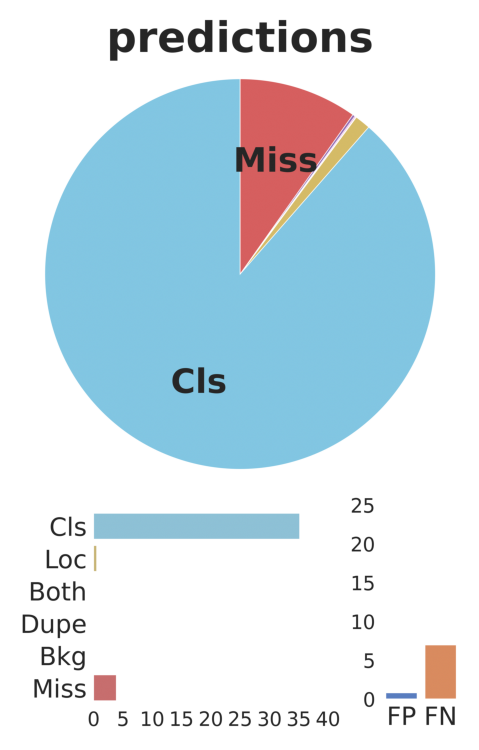

In [34]:
tide = TIDE()

tide.evaluate(datasets.COCO(labels_path), datasets.COCOResult(preds_path), mode=TIDE.BOX)
tide.summarize()
tide.plot()